In [1]:
# Imports
import polars as pl

## Create sets from John's annotations

In [2]:
cg_ann = pl.read_parquet("../1_snakemake/inputs/annotations/compound_gene.parquet")
meta = pl.read_parquet("../1_snakemake/inputs/metadata/metadata.parquet")
oasis = pl.read_csv("/Users/jewald/repos/2024_03_18_OASIS/2024_03_18_OASIS-data/data/2_reannotated_compiled_list/v5_oasis_03Sept2024_simple.csv")

oasis = oasis.with_columns(
    pl.col("INCHIKEY").str.slice(0,14).alias("INCHI_14")
).select(["OASIS_ID", "INCHI_14"])
cg_ann = cg_ann.with_columns(
    pl.col("inchikey").str.slice(0,14).alias("INCHI_14")
)

In [3]:
cg_summary = cg_ann.select(["rel_type", "source_id"]).unique()

In [5]:
remove = ["unknown", "vaccine", "DRUG_CATALYSIS_GENE", "DRUG_ENZYME", "enzyme"]

no_dir = ["DRUG_TARGET", "DRUG_REACTION_GENE", "modulator", 
          "BINDS_CHbG", "DPI", "target", "IS_ACTIVE_IN_METABOLISM_CHiaimG",
          "IS_ACTIVE_ON_DNA_OR_RNA_LEVEL_CHiaodorlG", "DRUG_CARRIER", "carrier",
          "transporter", "ASSOCIATES_CHaG", "IS_ACTIVE_ON_CELLULAR_LEVEL_CHiaoclG",
          "agonist,antagonist", "target", "DRUG_TRANSPORTER", "DRUG_BINDING_GENE",
          "CbG", "allosteric modulator", "antibody", "blocker,activator"]

down = ["DOWNREGULATES_CHdG", "CdG", "inverse agonist", "inhibitor", "INCREASES_DEGENERATION_CHidG", 
        "DRUG_INHIBITION_GENE", "DRUG_BINDINH_GENE", "antagonist", "blocker", "suppressor", 'blocker,inhibitor',
        "antisense oligonucleotide", "inhibitory allosteric modulator", "negative modulator", "antagonist,allosteric modulator"]

up = ["DRUG_BINDACT_GENE", "CuG", "positive modulator", "agonist", "UPREGULATES_CHuG",
      "DRUG_ACTIVATION_GENE", "DECREASES_DEGENERATION_CHddG", "activator", "partial agonist",
      'inducer', 'agonist,allosteric modulator']

all_cols = remove + no_dir + down + up

In [6]:
cg_ann = cg_ann.filter(~pl.col("rel_type").is_in(remove)).with_columns(
    pl.when(pl.col("rel_type").is_in(no_dir)).then(pl.lit("unknown_direction"))
    .when(pl.col("rel_type").is_in(up)).then(pl.lit("increases_activity"))
    .when(pl.col("rel_type").is_in(down)).then(pl.lit("decreases_activity")).alias("interaction_type")
)
cg_oasis = cg_ann.join(oasis, on="INCHI_14", how="inner")

In [9]:
cg_oasis = cg_oasis.unique()
cg_oasis.write_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/inputs/annotations/cg_motive.parquet")

In [62]:
cg = cg_ann.select(["target", "inchikey", "interaction_type"]).unique().filter(pl.col("inchikey").is_not_null())
cg.select("target").unique().write_csv("./results/gene_symbols.csv")

### Run mapping script in R

In [72]:
symbol_id = pl.read_csv("./results/symbol_ensembl.csv").rename({"hgnc_symbol": "target"})
cg = cg.join(symbol_id, on="target")

In [77]:
cg = cg.group_by(["inchikey", "interaction_type", "ensembl_gene_id"]).agg([
    pl.col("target").alias("target").str.concat(delimiter=",")
])
cg = cg.rename({"target": "hgnc_symbol"})

In [78]:
cg_hits_summary = cg.group_by(["target", "interaction_type"]).agg(pl.count())
gene_hits_summary = cg.group_by(["inchikey", "interaction_type"]).agg(pl.count())

## Create sets from MedChemXpress annotations

In [17]:
# Create annotation files from Axiom data
targets = meta.select(["Metadata_Compound", "Metadata_compound_target"]).filter(pl.col("Metadata_compound_target").is_not_null())
pathways = meta.select(["Metadata_Compound", "Metadata_compound_pathway"]).filter(pl.col("Metadata_compound_pathway").is_not_null())


In [18]:
targets = targets.with_columns(
    pl.col("Metadata_compound_target").str.split("; ").alias("Metadata_compound_target")
).explode("Metadata_compound_target").unique()

pathways = pathways.with_columns(
    pl.col("Metadata_compound_pathway").str.split("; ").alias("Metadata_compound_pathway")
).explode("Metadata_compound_pathway").unique()

In [19]:
target_counts = targets.group_by("Metadata_compound_target").count()
pathway_counts = pathways.group_by("Metadata_compound_pathway").count()

## Create sets from Srijit's annotations

## Get activation concentrations from ToxCast data

Get annotations from ToxCast.
Download latest version of invitrodb from here: https://clowder.edap-cluster.com/datasets/647f712de4b08a6b394e4281?space=647f710ee4b08a6b394e426b

Install mysql on Mac:
brew install mysql@8.0
brew link mysql@8.0 --force
brew services start mysql@8.0
brew services list

Create empty database to extract SQL dump to:
mysql -u root
CREATE DATABASE invitrodb_v4_1;
EXIT;

Unzip the compressed sql dump (expanded size is ~100GB):
gunzip invitrodb_v4_1_mysql.gz

Import into database we created earlier:
mysql -u root invitrodb_v4_1 < invitrodb_v4_1_mysql.sql

Log back in and verify data is there:
mysql -u root
USE prod_internal_invitrodb_v4_1;
SHOW TABLES;




In [13]:
import polars as pl

ann = pl.read_parquet("/Users/jewald/repos/2024_09_09_Axiom_OASIS/1_snakemake/inputs/annotations/seal_binary.parquet")

In [14]:
ann_cols = [i for i in ann.columns if "Toxcast" in i]

In [15]:
toxcast = ann.select(ann_cols)

In [16]:
not_tc = ann.drop(ann_cols)

In [17]:
def ratio_1_to_0(df: pl.DataFrame) -> pl.DataFrame:
    ratios = []
    for col in df.columns:
        # Count 1s and 0s in the column (ignoring NaNs)
        count_1 = df.select(col).drop_nulls().filter(pl.col(col) == 1).shape[0]
        count_0 = df.select(col).drop_nulls().filter(pl.col(col) == 0).shape[0]
        
        # Calculate the ratio and handle division by zero
        if count_0 > 0:
            ratio = count_1 / count_0
        else:
            ratio = None  # Or some other value to represent no 0s
        
        # Store the result
        ratios.append(ratio)

    # Return as a polars DataFrame
    return ratios

# Example usage with your dataframe 'df'
ratios = ratio_1_to_0(toxcast)

# Display the results
print(ratios)

ComputeError: cannot compare utf-8 with numeric data

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_33356/3213557769.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


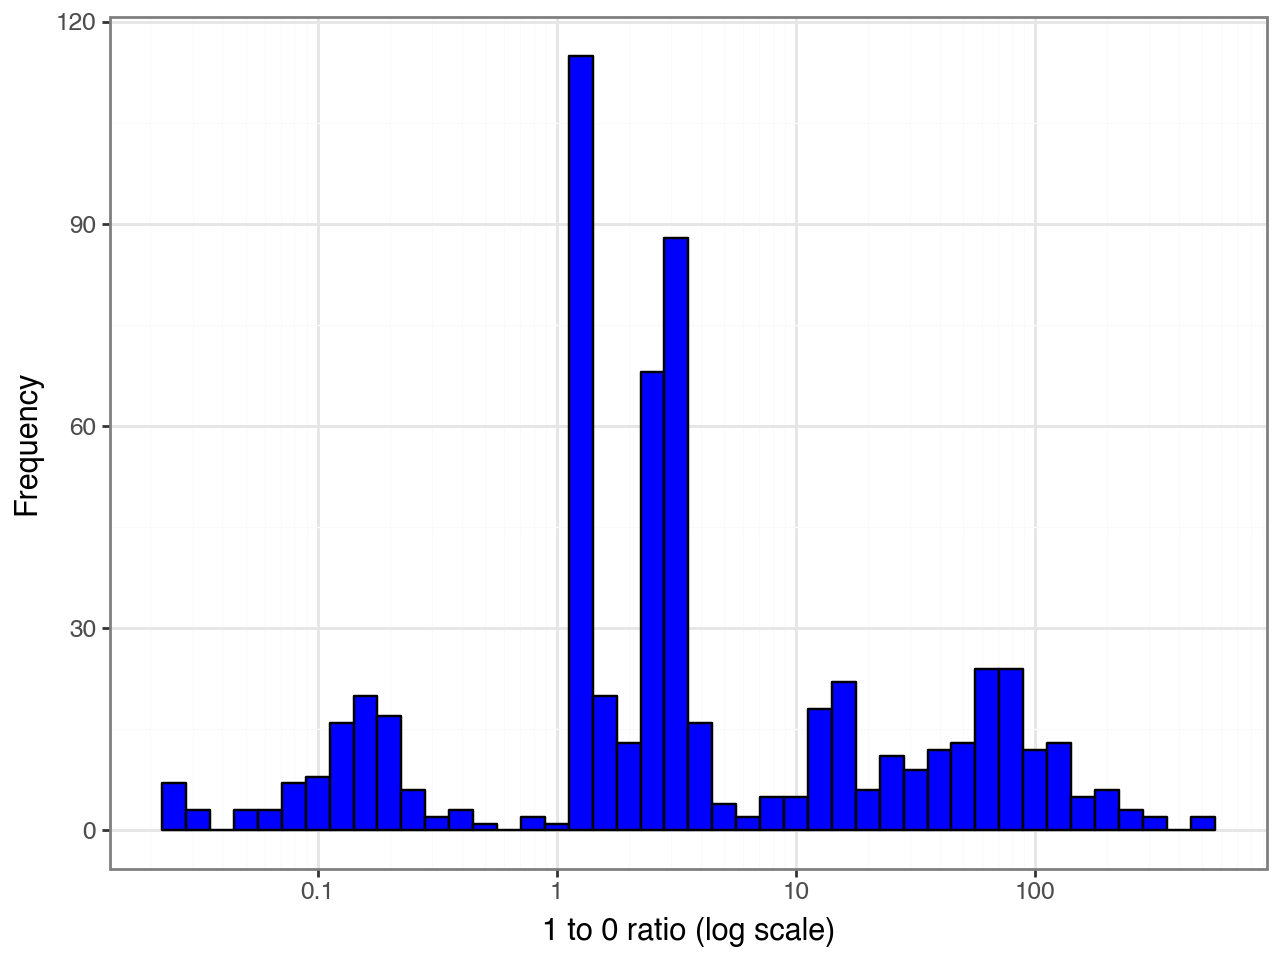

In [11]:
import pandas as pd
from plotnine import ggplot, aes, geom_histogram, scale_x_log10, labs, theme_bw

# Create a pandas DataFrame
df = pd.DataFrame({'values': ratios})

# Create the histogram using plotnine
plot = (
    ggplot(df, aes(x='values')) +
    geom_histogram(binwidth=0.1, fill='blue', color='black') +
    scale_x_log10() +
    labs(
        x='1 to 0 ratio (log scale)',
        y='Frequency'
    ) +
    theme_bw()
)

# Display the plot
print(plot)